# Обзор пакета автомачитеского машинного обучения auto-sklearn

Сегодня на сайте обзор библиотеки для автоматического машинного обучения под названием [auto-sklearn](https://github.com/automl/auto-sklearn). Эта библиотека практически не требует человеческого вмешательства, а все делает сама. С ее помощью, мне удалось занять 142 место (из 617 участников) в [соревновании по машинному обучению](http://mlbootcamp.ru/championship/10/) от mail.ru. Давайте посмотрим, что же это такое.

Загрузим данные в pandas и разобьем их на train и test. Обратите внимание, что я сразу конвертнул их во float64, т.к. auto-sklearn требует данные именно в таком формате.

In [1]:
import sklearn.metrics
from sklearn.cross_validation import train_test_split
import pandas as pd

X = pd.read_csv('mail_data/x_train.csv',';').astype('float64')
y = pd.read_csv('mail_data/y_train.csv',';',header=None).astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Импортируем классификатор и настраиваем его параметры.

In [2]:
import autosklearn.classification

In [3]:
automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task = int(1/12 * 3600),
        per_run_time_limit = int(1/12 * 360),
        ml_memory_limit = 128000,
        exclude_preprocessors = ['RandomTreesEmbedding']
        #resampling_strategy='cv',
        #resampling_strategy_arguments={'folds': 3}
)

Основным параметрами, которые нужно настраивать, являются time_left_for_this_task - ограничение по времени на поиск оптимальной модели и per_run_time_limit - ограничение по времени на запуск отдельных моделей машинного обучения. Здесь я начал с 5 минут на весь поиск и 30 секунд на отдельные алгоритмы. Так же можно выставить лимит на оперативную память (ml_memory_limit) и стратегию семплирования (resampling_strategy). Обратите внимание, что я исключил из модели препроцессинг по методу 'RandomTreesEmbedding' (он глючит на моей машине) и кросс-валидацию решил не использовать. Подробнее о параметрах auto-sklearn можно почитать в [api](https://automl.github.io/auto-sklearn/stable/api.html). Запустим оптимизацию. Сами данные я даже не смотрел - я знал только, что это задача классификации.

In [4]:
automl.fit(X_train.copy().values, y_train.copy().values.ravel())

[WARNING] [2017-03-21 09:12:36,048:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 09:12:36,048:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 09:12:36,051:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 09:12:36,051:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run6
You are already timing task: index_run9
You are already timing task: index_run10
You are already timing task: index_run10
You are already timing task: index_run10


Как и было задано - оптимизация шла 5 минут. Я так же сразу сохраню полученную модель в файл - эта хорошая привычка, т.к. когда вы будете запускать auto-sklearn на несколько дней, то будет очень обидно случайно потерять свои результаты.

In [5]:
import _pickle as cPickle
with open('mail_automl_5min.pkl', 'wb') as fid:
    cPickle.dump(automl, fid)

Посмотрим, что же получается на выходе.

In [6]:
print (automl.show_models())

[(0.340000, SimpleClassificationPipeline({'one_hot_encoding:use_minimum_fraction': 'True', 'one_hot_encoding:minimum_fraction': 0.0002695045315207182, 'classifier:libsvm_svc:shrinking': 'True', 'classifier:libsvm_svc:max_iter': -1, 'balancing:strategy': 'weighting', 'rescaling:__choice__': 'none', 'classifier:__choice__': 'libsvm_svc', 'imputation:strategy': 'mean', 'classifier:libsvm_svc:kernel': 'rbf', 'classifier:libsvm_svc:gamma': 0.10000000000000006, 'preprocessor:__choice__': 'no_preprocessing', 'classifier:libsvm_svc:C': 1.0, 'classifier:libsvm_svc:tol': 0.00010000000000000009},
dataset_properties={
  'sparse': False,
  'task': 1,
  'signed': False,
  'multilabel': False,
  'target_type': 'classification',
  'multiclass': False})),
(0.200000, SimpleClassificationPipeline({'one_hot_encoding:use_minimum_fraction': 'True', 'preprocessor:feature_agglomeration:n_clusters': 101, 'one_hot_encoding:minimum_fraction': 0.045645659641546966, 'preprocessor:feature_agglomeration:pooling_func

На выходе имеем ансамбль из нескольких моделей с разными весами. Все параметры моделей явно прописаны и при желании их, наверное, можно воспроизвести стандартными средствами sklearn (я правда не пробовал этого делать). Посмотрим на качество модели - сделать это легко, т.к. объекты auto-sklearn имеют привычные методы обычного sklearn. Посчитаем accuracy.

In [7]:
predictions = automl.predict(X_test.values)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test.values, predictions))

Accuracy score 0.824304731778


Посмотрим на roc auc на train и test.

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
def get_roc(model,X,y):
    from sklearn.metrics import roc_curve, auc
    pred = model.predict_proba(X.copy().values)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [10]:
def plot_test_train_roc(model, X_train, X_test, y_train, y_test):
    fpr_test, tpr_test, roc_auc_test = get_roc(model,X_test,y_test)
    fpr_train, tpr_train, roc_auc_train = get_roc(model,X_train,y_train)
    plt.figure()
    plt.plot(fpr_test, tpr_test, label='ROC curve (area = %0.2f) test' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, label='ROC curve (area = %0.2f) train' % roc_auc_train)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

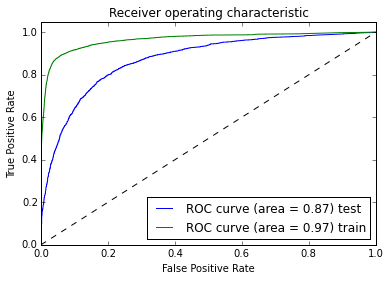

In [11]:
plot_test_train_roc(automl, X_train, X_test, y_train, y_test)

Здесь можно увидеть, что модель получилась достаточно сильно переобученной - об этом свидетельствует большая дельта между roc auc на train и test. Попробуем снизить переобучение и погонять оптимизацию чуть подольше, а так же добавим кросс-валидацию по 3 фолдам. Обратите внимание, что параметры time_left_for_this_task и per_run_time_limit я настраиваю в связке, только для простоты демонстрации. Если вы поставите оптимизацию на день или больше, то per_run_time_limit должен быть не меньше, чем время, требующееся для обучения одной мощной модели (например, случайного леса).

In [12]:
automl2 = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task = int(1 * 3600),
        per_run_time_limit = int(1 * 360),
        ml_memory_limit=128000,
        exclude_preprocessors = ['RandomTreesEmbedding'],
        resampling_strategy = 'cv',
        resampling_strategy_arguments={'folds': 3}
)

Auto-sklearn позволяет пользователю выбирать функцию, которая будет оптимизироваться. По умолчанию стоит accuracy. Давайте поставим, чтобы он оптимизировал, например, [f1](https://en.wikipedia.org/wiki/F1_score). Кстати, в методе fit так же имеется параметр feat_type, в котором можно указать, какие из ваших переменных категориальные - тогда auto-sklearn автоматически сделает one hot encoding.

In [13]:
automl2.fit(X_train.copy().values, y_train.copy().values.ravel(),metric='f1_metric')

You are already timing task: index_run8
You are already timing task: index_run9
You are already timing task: index_run10
You are already timing task: index_run10
You are already timing task: index_run15


[WARNING] [2017-03-21 09:47:28,110:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 09:47:28,110:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run16
You are already timing task: index_run18
You are already timing task: index_run19
You are already timing task: index_run21
You are already timing task: index_run22


n_components is too large: it will be set to 12
n_components is too large: it will be set to 12
n_components is too large: it will be set to 12


You are already timing task: index_run23


[WARNING] [2017-03-21 10:03:42,516:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 10:03:42,516:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run23
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run25


[WARNING] [2017-03-21 10:11:02,456:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 10:11:02,456:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run25
You are already timing task: index_run25


[WARNING] [2017-03-21 10:15:25,747:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 10:15:25,747:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26


[WARNING] [2017-03-21 10:16:36,774:intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-03-21 10:16:36,774:intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run26


Если в auto-sklearn используется стратегий кросс-валидации, то модель обязательно требует вызвать метод refit, чтобы обучиться на всех данных.

In [14]:
automl2.refit(X_train.copy().values, y_train.copy().values.ravel())

n_components is too large: it will be set to 12


AutoML(acquisition_function='EI', backend=None, configuration_mode=None,
    debug_mode=None, delete_output_folder_after_terminate=None,
    delete_tmp_folder_after_terminate=None, disable_evaluator_output=None,
    ensemble_nbest=None, ensemble_size=None, exclude_estimators=None,
    exclude_preprocessors=None, include_estimators=None,
    include_preprocessors=None,
    initial_configurations_via_metalearning=None, keep_models=None,
    log_dir=None, max_iter_smac=None, metadata_directory=None,
    ml_memory_limit=None, per_run_time_limit=None, precision=32,
    resampling_strategy=None, resampling_strategy_arguments=None,
    seed=None, shared_mode=None, time_left_for_this_task=None)

In [15]:
import _pickle as cPickle
with open('mail_automl_1hour.pkl', 'wb') as fid:
    cPickle.dump(automl2, fid)

Построим roc.

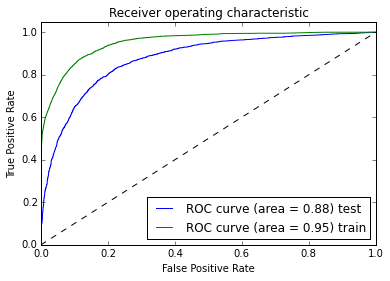

In [16]:
plot_test_train_roc(automl2, X_train, X_test, y_train, y_test)

Переобучение осталось, но немного снизилось. Плюс увеличился roc на тесте - это хорошо. Модель, результаты которой я постил на соревновании, оптимизировалась несколько дней и ее показатели качества были еще лучше. Да, кстати, если вы используете hold-out выборку, т.е. сами разбиваете на train и test, то перед предсказанием результатов на реальном тесте нужно обучить полученную модель на всех данных. Для этого так же следует использовать метод refit.

In [17]:
automl.refit(X.copy().values, y.copy().values.ravel())

AutoML(acquisition_function='EI', backend=None, configuration_mode=None,
    debug_mode=None, delete_output_folder_after_terminate=None,
    delete_tmp_folder_after_terminate=None, disable_evaluator_output=None,
    ensemble_nbest=None, ensemble_size=None, exclude_estimators=None,
    exclude_preprocessors=None, include_estimators=None,
    include_preprocessors=None,
    initial_configurations_via_metalearning=None, keep_models=None,
    log_dir=None, max_iter_smac=None, metadata_directory=None,
    ml_memory_limit=None, per_run_time_limit=None, precision=32,
    resampling_strategy=None, resampling_strategy_arguments=None,
    seed=None, shared_mode=None, time_left_for_this_task=None)

После его завершения можно делать предсказания и постить результат.

Выводы:

1. Auto-sklearn дает неплохие результаты при минимуме усилий. Если добавить сюда еще какой-то маломальский feature engineering, то можно получить очень хорошие результаты.
1. Качество модели на auto-sklearn может служить отправной точкой вашего исследования. Roc auc полученный на авто-обучение можно использовать как некий base line для сравнения с моделями, которые вы создадите сами.
1. С помощью auto-sklearn можно очень быстро оценить потенциал данных, которые вы собираетесь использовать в решении той или иной задачи. Если автоматическая модель дает совсем плохие результаты - значит нужно подумать над расширением списка используемых переменных и найти какую-то дополнительную информацию по исследуемому процессу.